### IMPORTING PACKAGES

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql import DataFrame
import pandas as pd
from pyspark.sql.functions import (
    min, max, year, month, col, isnan, isnull, when, count, countDistinct, 
    round, desc, sum as sum_, mean, stddev, variance, skewness, kurtosis, 
    explode, split, regexp_replace, to_timestamp, to_date, lit, datediff, current_date
)
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
from functools import reduce
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.sql.window import Window
from pyspark.sql.functions import create_map, lit
from itertools import chain
from pyspark.sql.functions import avg as F_avg
from pyspark.sql.functions import sum as F_sum
from pyspark.sql.functions import count as F_count
from pyspark.sql.functions import col, round as F_round
from pyspark.sql.functions import log1p 
import seaborn as sns
from pyspark.ml.stat import Correlation
import numpy as np
import pylab as pl
from pyspark.ml.linalg import Vectors

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
# Changing the directory in the Colab notebook to a specific location within the Google Drive
%cd C:\Users\june3\OneDrive\Documents\SDWA_SAMPLE\

C:\Users\june3\OneDrive\Documents\SDWA_SAMPLE


### CREATE SPARK SESSION

In [4]:
# Step 1: Create a SparkSession
spark = SparkSession.builder \
    .appName("SDWA EDA Analysis") \
    .getOrCreate()

### LOADING .CSV FILES AND READING INTO SPARK DATAFRAMES

In [5]:
# Step 2: Read all CSV files into a list of Spark DataFrames
df = spark.read.csv("cleaned_data.csv", header=True, inferSchema=True)

In [6]:
def get_missing_values(df, dataframe_name):
    # Compute missing values for each column
    missing_df = df.select([
        count(when(isnull(c) | isnan(c), c)).alias(c) for c in df.columns
    ])
    
    # Convert to Pandas for better formatting
    missing = missing_df.toPandas().transpose().reset_index()
    missing.columns = ['Column', 'Missing_Count']
    
    # Display the missing values
    print(f"--- Missing Values in {dataframe_name} ---")
    print(missing.to_markdown(index=False))
    print("\n")

In [7]:
def get_summary_statistics(df, dataframe_name):
    # Compute summary statistics
    summary = df.describe().toPandas().set_index('summary').transpose()
    
    # Rename the index to the dataframe name for clarity
    summary.index.name = 'Column'
    
    # Display the summary statistics
    print(f"--- Summary Statistics for {dataframe_name} ---")
    print(summary.to_markdown())
    print("\n")

In [8]:
def get_unique_counts(df, dataframe_name):
    
    # Compute unique counts for each column
    unique_df = df.select([countDistinct(col(c)).alias(c) for c in df.columns])
    
    # Convert to Pandas DataFrame for better formatting
    unique = unique_df.toPandas().transpose().reset_index()
    unique.columns = ['Column', 'Unique_Count']
    
    # Display unique counts
    print(f"--- Unique Value Counts in {dataframe_name} ---")
    print(unique.to_markdown(index=False))
    print("\n")

### DESCRIPTIVE STATISTICS

##### Summary Statistics

In [72]:
cat_vars = df_combined.select("PWS_ACTIVITY_CODE", 
            "IS_SCHOOL_OR_DAYCARE_IND",
            "SOURCE_WATER_PROTECTION_CODE", 
            "OUTSTANDING_PERFORMER",
            "MANAGEMENT_OPS_EVAL_CODE",
            "SOURCE_WATER_EVAL_CODE",
            "SECURITY_EVAL_CODE",
            "PUMPS_EVAL_CODE",
            "OTHER_EVAL_CODE",
            "COMPLIANCE_EVAL_CODE",
            "DATA_VERIFICATION_EVAL_CODE",
            "TREATMENT_EVAL_CODE",
            "FINISHED_WATER_STOR_EVAL_CODE",
            "DISTRIBUTION_EVAL_CODE",
            "FINANCIAL_EVAL_CODE",
            "VIOLATION_CATEGORY_CODE",
            "IS_HEALTH_BASED_IND",
            "IS_MAJOR_VIOL_IND",
            "VIOLATION_STATUS",
            "ENF_ACTION_CATEGORY",
           "COMPLIANCE_STATUS")

In [73]:
num_vars = df_combined.select("TOTAL_POPULATION_SERVED_COUNT",
            "TOTAL_SERVICE_CONNECTIONS_COUNT",
            "VIOL_MEASURE",
            "TOTAL_VIOLATIONS",
            "TOTAL_ENFORCEMENTS",
            "AVG_VIOLATION_DURATION_DAYS",
            "OPEN_VIOLATIONS_COUNT",
            "TOTAL_LATE_COMPLIANT_ACTIONS"
                             )

In [85]:
get_summary_statistics(num_vars, "Numerical Statistics")

--- Summary Statistics for Numerical Statistics ---
| Column                          |   count |          mean |       stddev |   min |           max |
|:--------------------------------|--------:|--------------:|-------------:|------:|--------------:|
| TOTAL_POPULATION_SERVED_COUNT   |   43073 | 3229.27       | 31672.9      |     0 |      2.66e+06 |
| TOTAL_SERVICE_CONNECTIONS_COUNT |   43073 | 1068.86       |  9801.05     |     0 | 954657        |
| VIOL_MEASURE                    |   43073 |    9.41772    |   600.964    |     0 |  58000        |
| TOTAL_VIOLATIONS                |   43073 |   23.1536     |    63.5385   |     1 |   2810        |
| TOTAL_ENFORCEMENTS              |   43073 |   20.2164     |    62.4252   |     0 |   2809        |
| AVG_VIOLATION_DURATION_DAYS     |   43073 |  368.189      |   806.53     |     0 |  36973        |
| OPEN_VIOLATIONS_COUNT           |   43073 |    0.00800966 |     0.158659 |     0 |     12        |
| TOTAL_LATE_COMPLIANT_ACTIONS    |   4

In [74]:
def calculate_skewness_kurtosis(df, dataframe_name):
    # Iterate through all columns in the DataFrame
    for col in df.columns:
        # Calculate skewness and kurtosis for the column
        stats = df.agg(
            skewness(col).alias("Skewness"),
            kurtosis(col).alias("Kurtosis")
        ).toPandas()
        
        # Transpose the DataFrame to have statistics as rows
        stats = stats.transpose().reset_index()
        stats.columns = ['Statistic', 'Value']
        
        # Display the results
        print(f"--- Statistics for {col} ---")
        print(stats.to_markdown())
        
        print("\n")

In [88]:
calculate_skewness_kurtosis(num_vars, "Numberical Statistics")

--- Statistics for TOTAL_POPULATION_SERVED_COUNT ---
|    | Statistic   |     Value |
|---:|:------------|----------:|
|  0 | Skewness    |   43.2019 |
|  1 | Kurtosis    | 2603.17   |


--- Statistics for TOTAL_SERVICE_CONNECTIONS_COUNT ---
|    | Statistic   |     Value |
|---:|:------------|----------:|
|  0 | Skewness    |   46.2973 |
|  1 | Kurtosis    | 3295.05   |


--- Statistics for VIOL_MEASURE ---
|    | Statistic   |     Value |
|---:|:------------|----------:|
|  0 | Skewness    |   85.8143 |
|  1 | Kurtosis    | 7440.33   |


--- Statistics for TOTAL_VIOLATIONS ---
|    | Statistic   |    Value |
|---:|:------------|---------:|
|  0 | Skewness    |  10.6993 |
|  1 | Kurtosis    | 233.241  |


--- Statistics for TOTAL_ENFORCEMENTS ---
|    | Statistic   |    Value |
|---:|:------------|---------:|
|  0 | Skewness    |  10.9231 |
|  1 | Kurtosis    | 244.366  |


--- Statistics for AVG_VIOLATION_DURATION_DAYS ---
|    | Statistic   |    Value |
|---:|:------------|---------

### UNIVARIATE ANALYSIS

In [75]:
# List of columns to apply log transformation
columns_to_transform = [
    'TOTAL_POPULATION_SERVED_COUNT', 
    'TOTAL_SERVICE_CONNECTIONS_COUNT', 
    'VIOL_MEASURE', 
    'TOTAL_VIOLATIONS',
    'TOTAL_ENFORCEMENTS',
    'AVG_VIOLATION_DURATION_DAYS', 
    'OPEN_VIOLATIONS_COUNT', 
    'TOTAL_LATE_COMPLIANT_ACTIONS'
]

# Initialize df_transformed with df_combined before the loop
df_transformed = df_combined

# Apply log1p transformation to each column and add as new columns
for col in columns_to_transform:
    df_transformed = df_transformed.withColumn(col + '_LOG', F.log1p(F.col(col)))

In [ ]:
# df_transformed = df_transformed.drop("TOTAL_POPULATION_SERVED_COUNT", "TOTAL_SERVICE_CONNECTIONS_COUNT", "VIOL_MEASURE",
#                                      "TOTAL_VIOLATIONS", "TOTAL_ENFORCEMENTS", "AVG_VIOLATION_DURATION_DAYS", 
#                                      "OPEN_VIOLATIONS_COUNT", "TOTAL_LATE_COMPLIANT_ACTIONS")

In [76]:
num_vars_transformed = df_transformed.select("TOTAL_POPULATION_SERVED_COUNT_LOG",
            "TOTAL_SERVICE_CONNECTIONS_COUNT_LOG",
            "VIOL_MEASURE_LOG",
            "TOTAL_VIOLATIONS_LOG",
            "TOTAL_ENFORCEMENTS_LOG",
            "AVG_VIOLATION_DURATION_DAYS_LOG",
            "OPEN_VIOLATIONS_COUNT_LOG",
            "TOTAL_LATE_COMPLIANT_ACTIONS_LOG"
                             )

In [91]:
get_summary_statistics(num_vars_transformed, "Numerical Statistics")

--- Summary Statistics for Numerical Statistics ---
| Column                              |   count |       mean |   stddev |      min |      max |
|:------------------------------------|--------:|-----------:|---------:|---------:|---------:|
| TOTAL_POPULATION_SERVED_COUNT_LOG   |   43073 | 5.38068    | 2.07433  | 0        | 14.7938  |
| TOTAL_SERVICE_CONNECTIONS_COUNT_LOG |   43073 | 3.7166     | 2.44992  | 0        | 13.7691  |
| VIOL_MEASURE_LOG                    |   43073 | 0.287177   | 0.859933 | 0        | 10.9682  |
| TOTAL_VIOLATIONS_LOG                |   43073 | 2.21626    | 1.2199   | 0.693147 |  7.9413  |
| TOTAL_ENFORCEMENTS_LOG              |   43073 | 1.75989    | 1.46489  | 0        |  7.94094 |
| AVG_VIOLATION_DURATION_DAYS_LOG     |   43073 | 5.02701    | 1.27249  | 0        | 10.518   |
| OPEN_VIOLATIONS_COUNT_LOG           |   43073 | 0.00427881 | 0.066427 | 0        |  2.56495 |
| TOTAL_LATE_COMPLIANT_ACTIONS_LOG    |   43073 | 0.668899   | 1.05777  | 0        |

In [77]:
calculate_skewness_kurtosis(num_vars_transformed, "Transformed Numerical Statistics")

--- Statistics for TOTAL_POPULATION_SERVED_COUNT_LOG ---
|    | Statistic   |    Value |
|---:|:------------|---------:|
|  0 | Skewness    | 0.278474 |
|  1 | Kurtosis    | 0.985213 |


--- Statistics for TOTAL_SERVICE_CONNECTIONS_COUNT_LOG ---
|    | Statistic   |     Value |
|---:|:------------|----------:|
|  0 | Skewness    |  0.516236 |
|  1 | Kurtosis    | -0.446249 |


--- Statistics for VIOL_MEASURE_LOG ---
|    | Statistic   |    Value |
|---:|:------------|---------:|
|  0 | Skewness    |  3.25689 |
|  1 | Kurtosis    | 11.996   |


--- Statistics for TOTAL_VIOLATIONS_LOG ---
|    | Statistic   |    Value |
|---:|:------------|---------:|
|  0 | Skewness    | 0.804819 |
|  1 | Kurtosis    | 0.290857 |


--- Statistics for TOTAL_ENFORCEMENTS_LOG ---
|    | Statistic   |     Value |
|---:|:------------|----------:|
|  0 | Skewness    |  0.653025 |
|  1 | Kurtosis    | -0.158349 |


--- Statistics for AVG_VIOLATION_DURATION_DAYS_LOG ---
|    | Statistic   |     Value |
|---:|:-

### BIVARIATE & MULTIVARIATE ANALYSIS

In [78]:
numerical_cols = ["TOTAL_POPULATION_SERVED_COUNT",
            "TOTAL_SERVICE_CONNECTIONS_COUNT",
            "VIOL_MEASURE",
            "TOTAL_VIOLATIONS",
            "TOTAL_ENFORCEMENTS",
            "AVG_VIOLATION_DURATION_DAYS",
            "OPEN_VIOLATIONS_COUNT",
            "TOTAL_LATE_COMPLIANT_ACTIONS"
           ]

In [1]:
# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features_vector")
df_corr = assembler.transform(df_transformed).select("features_vector")

# Compute the Pearson correlation matrix
pearson_corr_matrix = Correlation.corr(df_corr, "features_vector", "pearson").collect()[0][0]

# Convert to Pandas DataFrame for better visualization
corr_array = np.array(pearson_corr_matrix.toArray())
corr_df = pd.DataFrame(corr_array, index=numerical_cols, columns=numerical_cols)

print("--- Pearson Correlation Matrix ---")

In [71]:
corr_df

,TOTAL_POPULATION_SERVED_COUNT,TOTAL_SERVICE_CONNECTIONS_COUNT,VIOL_MEASURE,TOTAL_VIOLATIONS,AVG_VIOLATION_DURATION_DAYS,OPEN_VIOLATIONS_COUNT,TOTAL_LATE_COMPLIANT_ACTIONS
TOTAL_POPULATION_SERVED_COUNT,1.000000,0.816289,-0.001218,-0.006863,0.002974,-0.004343,-0.003831
TOTAL_SERVICE_CONNECTIONS_COUNT,0.816289,1.000000,-0.001383,-0.005636,-0.007883,-0.004693,-0.002124
VIOL_MEASURE,-0.001218,-0.001383,1.000000,-0.002040,-0.003528,-0.000764,0.001340
TOTAL_VIOLATIONS,-0.006863,-0.005636,-0.002040,1.000000,-0.047449,0.019707,0.665266
AVG_VIOLATION_DURATION_DAYS,0.002974,-0.007883,-0.003528,-0.047449,1.000000,0.214817,-0.030100
OPEN_VIOLATIONS_COUNT,-0.004343,-0.004693,-0.000764,0.019707,0.214817,1.000000,0.012409
TOTAL_LATE_COMPLIANT_ACTIONS,-0.003831,-0.002124,0.001340,0.665266,-0.030100,0.012409,1.000000


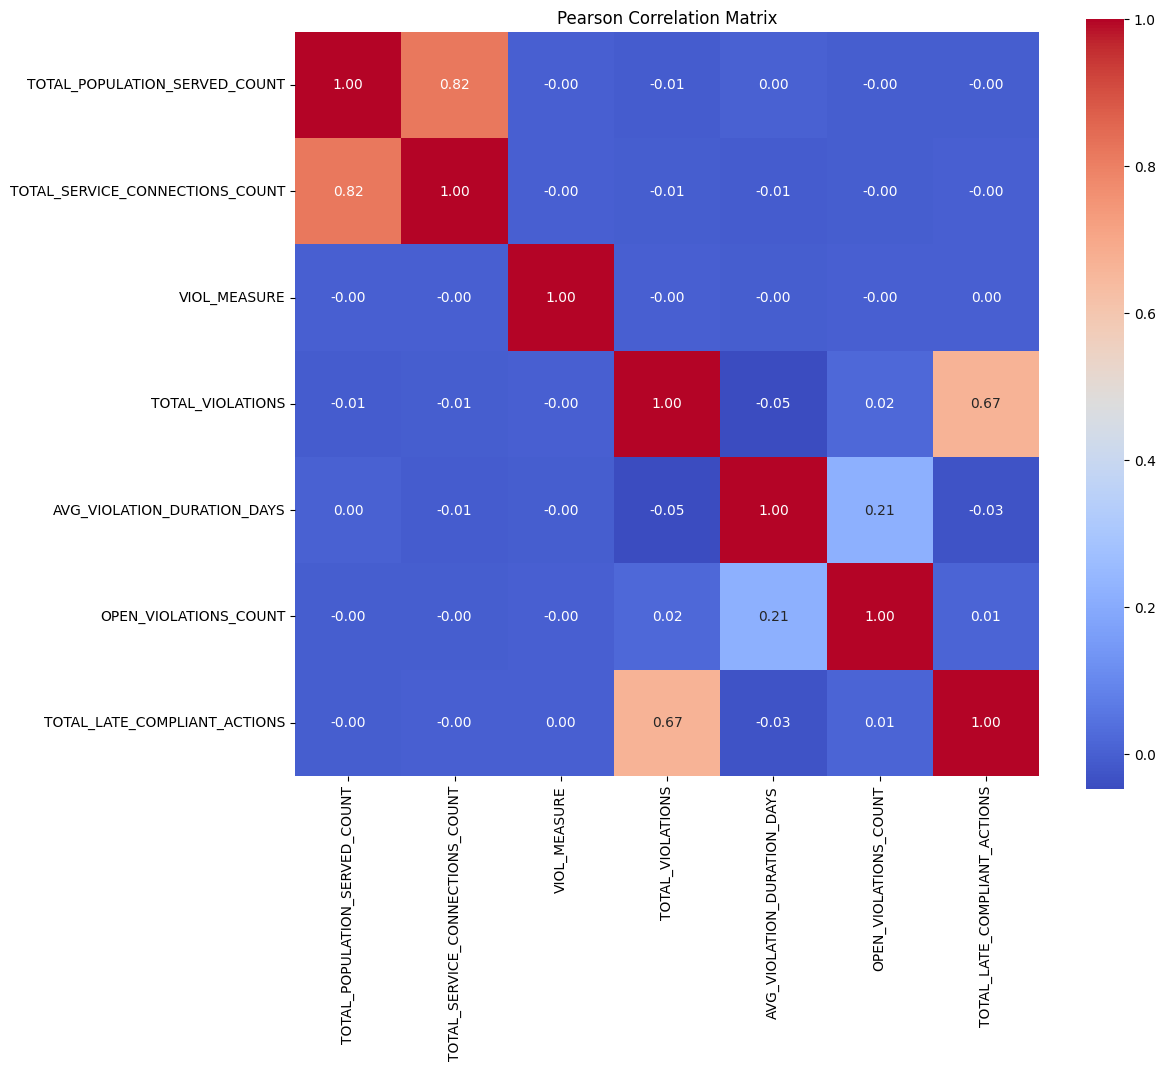

In [73]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Pearson Correlation Matrix')
plt.show()

In [ ]:
# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=num_vars_transformed, outputCol="features_vector")
df_corr1 = assembler.transform(df_transformed).select("features_vector")

# Compute the Pearson correlation matrix
pearson_corr_matrix1 = Correlation.corr(df_corr1, "features_vector", "pearson").collect()[0][0]

# Convert to Pandas DataFrame for better visualization
corr_array1 = np.array(pearson_corr_matrix11.toArray())
corr_df1 = pd.DataFrame(corr_array1, index=num_vars_transformed, columns=num_vars_transformed)

print("--- Pearson Correlation Matrix ---")

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df1, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Pearson Correlation Matrix')
plt.show()

In [90]:
# Extract unique correlations (upper triangle)
upper_triangle_indices = np.triu_indices(len(corr_df), k=1)

# Create a DataFrame with unique pairs
unique_pairs = pd.DataFrame({
    'Variable 1': corr_df.index[upper_triangle_indices[0]],
    'Variable 2': corr_df.columns[upper_triangle_indices[1]],
    'Correlation': corr_df.values[upper_triangle_indices]
})

print("\n--- Unique Correlation Pairs ---")
print(unique_pairs.round(2).to_markdown())

In [91]:
# Sample the data for visualization
sample_fraction = 0.1  # 10% sample to reduce memory usage
sample_df = df_joined.sample(fraction=sample_fraction).toPandas()


# Identify highly correlated pairs
threshold = 0.5
high_corr_pairs = []

for i in range(len(numerical_cols)):
    for j in range(i+1, len(numerical_cols)):
        corr_value = corr_df.iloc[i, j]
        if abs(corr_value) > threshold:
            high_corr_pairs.append((corr_df.index[i], corr_df.columns[j], corr_value))

print("--- Highly Correlated Pairs (|Correlation| > 0.7) ---")
for pair in high_corr_pairs:
    print(f"{pair[0]} & {pair[1]}: Correlation = {pair[2]:.2f}")

In [92]:
# Plot scatter plots for highly correlated pairs
for pair in high_corr_pairs:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=pair[0],
        y=pair[1],
        data=sample_df,
        alpha=0.5
    )
    plt.title(f"Scatter Plot: {pair[0]} vs {pair[1]} (Corr = {pair[2]:.2f})")
    plt.xlabel(pair[0])
    plt.ylabel(pair[1])
    plt.show()

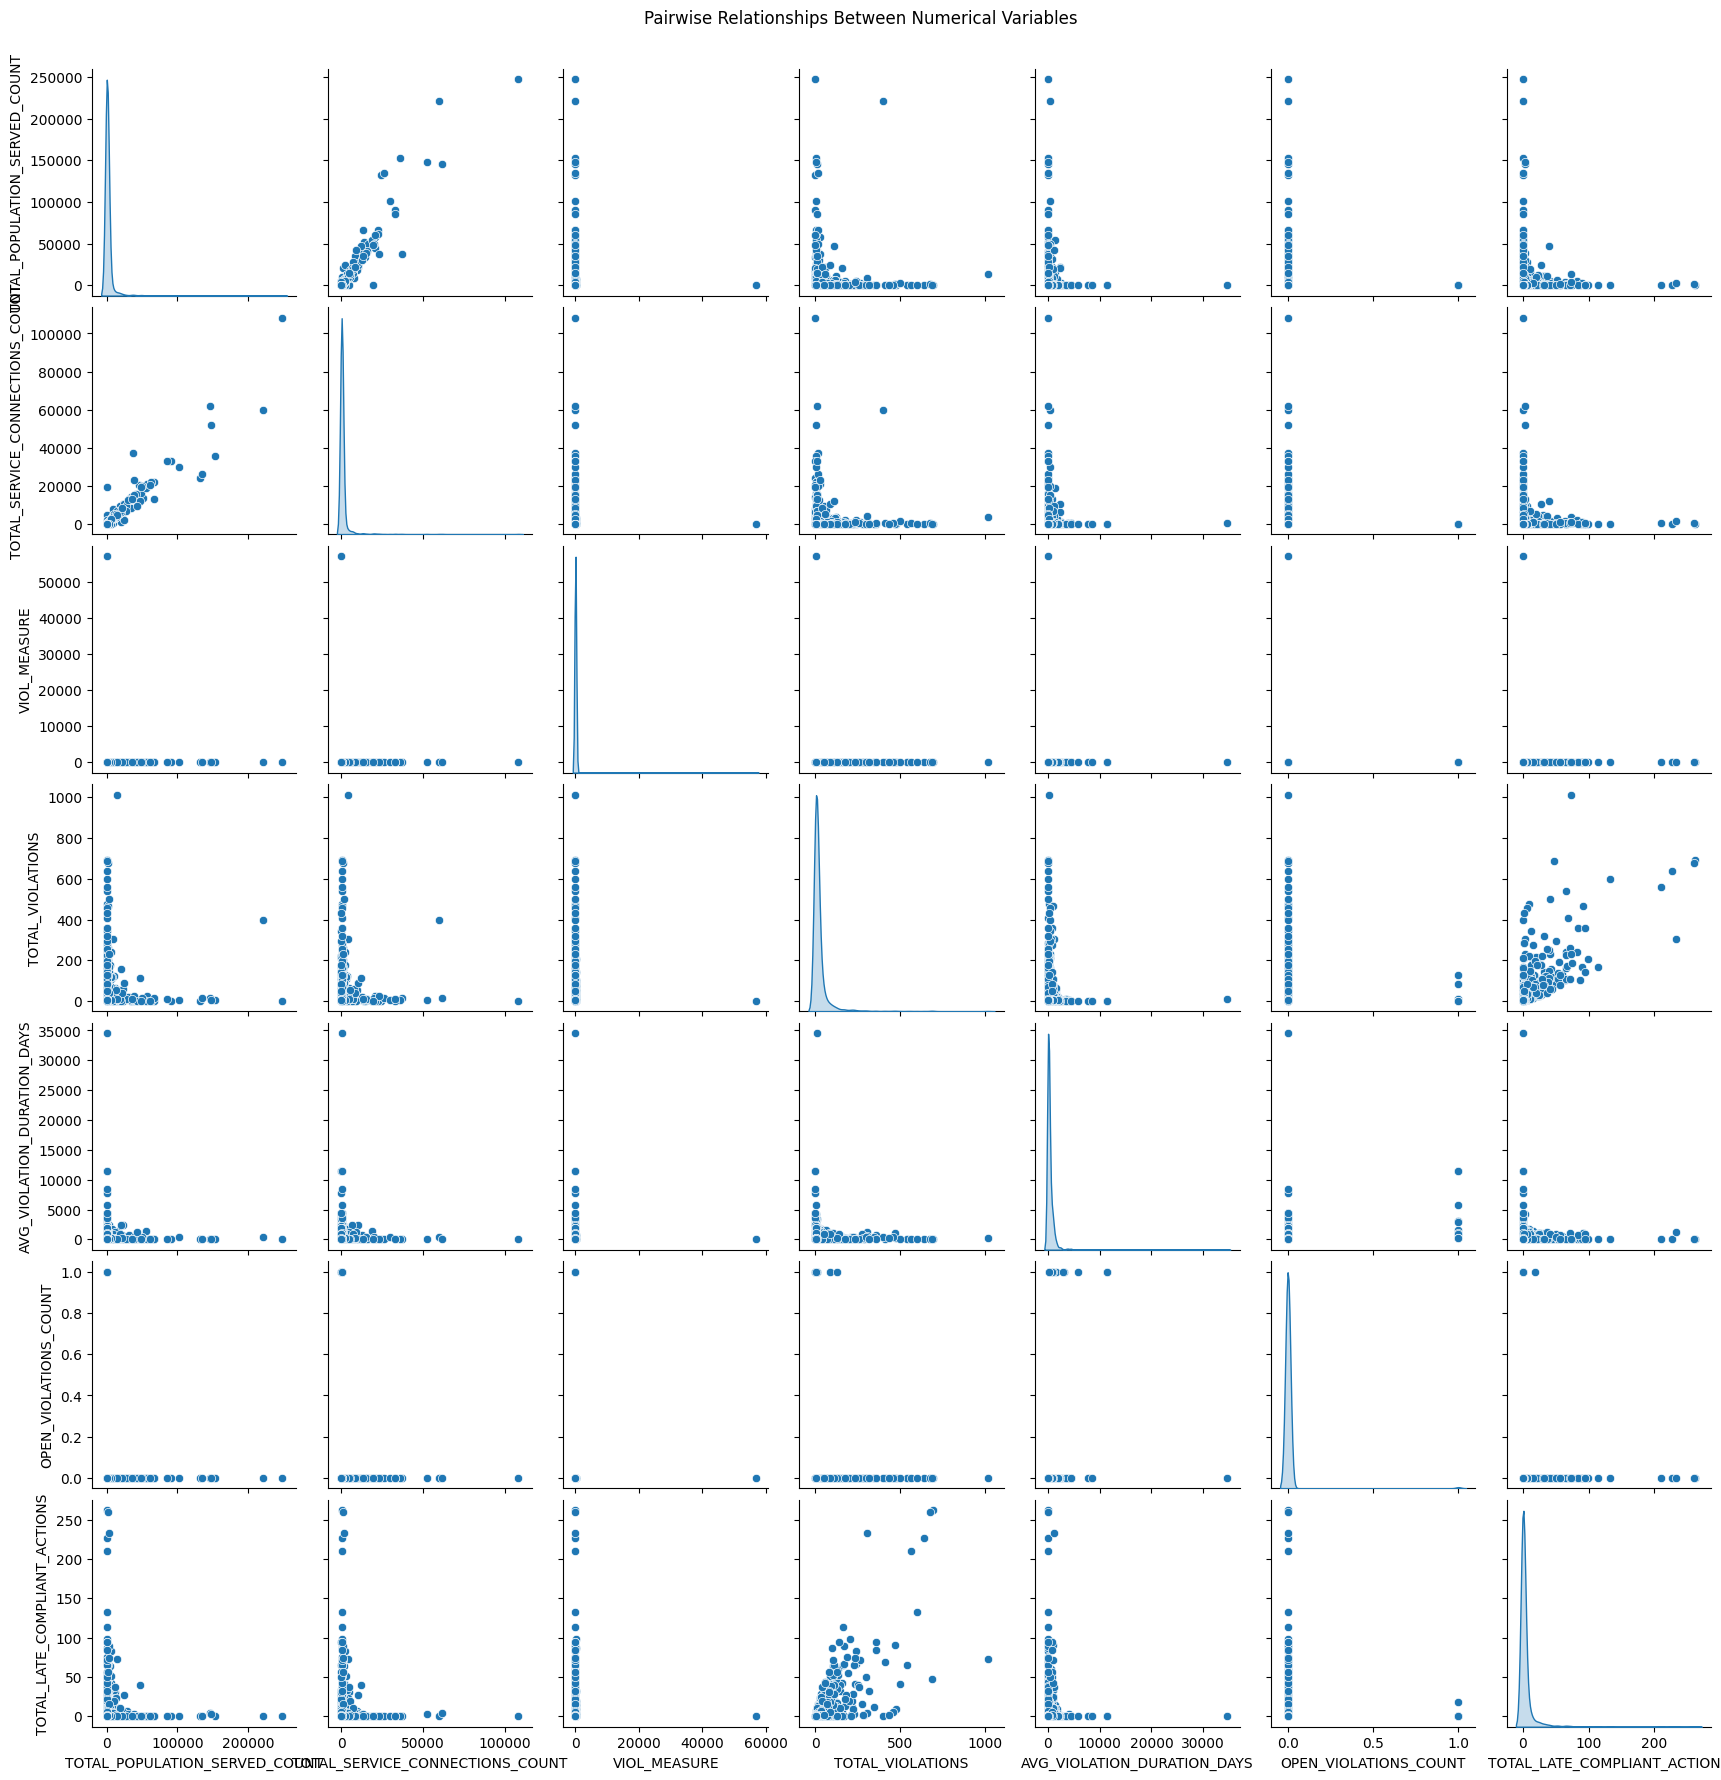

In [74]:
# Sample a subset for pairplot
pairplot_sample = num_vars.select(numerical_cols).sample(fraction=0.05).toPandas()

# Pairplot
sns.pairplot(pairplot_sample, diag_kind='kde')
plt.suptitle('Pairwise Relationships Between Numerical Variables', y=1.02)
plt.show()

In [27]:
df_transformed  = df_transformed.toPandas()

In [28]:
df_transformed.to_csv('C:/Users/june3/OneDrive/Desktop/my_output_result/eda_analysis.csv', index=False)  

In [83]:
spark.stop()